In [1]:
import os
if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd

import sys
sys.path.append('../')
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [2]:
# save_name = 'beta_event_t10000_01152021_161512'
save_name = 'beta_event_expanse_t100000_02142021_182526'
# save_name ='beta_event_basket_ampa_t10000_02222021_115049'
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/beta/prerun_simulations/' + save_name + '/'

prior_dict_file = open(data_path + 'prior_dict_' + save_name + '.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_' + save_name + '.pkl', 'rb')
prior = dill.load(prior_file)   
prior_file.close()

# params_fname_file = open(data_path + 'params_fname_' + save_name + '.pkl', 'rb')
# params_fname = dill.load(params_fname_file)
# params_fname_file.close()
params_fname = '../../data/beta/params/beta_param.param'

dpl_files = sorted(glob.glob(data_path + 'data/*dpl*sim*'))
theta_files = sorted(glob.glob(data_path + 'data/*theta*sim*'))
# spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
# spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
# spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [3]:

dpl_all = np.vstack([np.loadtxt(dpl_files[file_idx],delimiter=',')[:,::100] for file_idx in [0]])
theta_all = np.vstack([np.loadtxt(theta_files[file_idx],delimiter=',') for file_idx in [0]])
# dpl_all = np.vstack([np.loadtxt(dpl_files[file_idx],delimiter=',')[:,::100] for file_idx in range(len(dpl_files))])
# theta_all = np.vstack([np.loadtxt(theta_files[file_idx],delimiter=',') for file_idx in range(len(theta_files))])

# Load downsampled data
# dpl_all = np.loadtxt(data_path + 'dpl_100x_downsample.csv', delimiter=',')
# dpl_all = np.loadtxt(data_path + 'dpl_200-400ms_cropped_100x_downsample.csv', delimiter=',')
# theta_all = np.loadtxt(data_path + 'theta_all.csv', delimiter=',')
sim_length = 500 # in ms
sim_times_all = np.linspace(0,sim_length, dpl_all.shape[1])

#Filter to subthreshold events
threshold = 200
threshold_mask  = np.all(np.abs(dpl_all) < threshold, axis=1)
dpl_subthreshold = dpl_all[threshold_mask,:]
theta = theta_all[threshold_mask,:]

#Remove initialization transient
# sim_tstart, sim_t_end = 145, 345
sim_tstart, sim_t_end = 145, 345
sim_times_mask = np.logical_and(sim_times_all > sim_tstart, sim_times_all < sim_t_end)
sim_times = sim_times_all[sim_times_mask]
dpl = dpl_subthreshold[:, sim_times_mask]

#Load patient data
beta23 = np.loadtxt('../../data/beta/aging_grant/S1_23.txt')
beta43 = np.loadtxt('../../data/beta/aging_grant/S10_43.txt')

#convert time to ms
beta23[:,0] = beta23[:,0] * 1e3
beta43[:,0] = beta43[:,0] * 1e3

#Interpolate patient EEG to match simulation timepoints
num_pts = dpl.shape[1]
# real_tstart, real_t_end = 200, 400 
real_tstart, real_t_end = 220, 420 

new_times = np.linspace(real_tstart,real_t_end,num_pts)

beta23_interp_func = interpolate.interp1d(beta23[:,0], beta23[:,1], kind='cubic')
beta23_dpl = beta23_interp_func(new_times)

beta43_interp_func = interpolate.interp1d(beta43[:,0], beta43[:,1], kind='cubic')
beta43_dpl = beta43_interp_func(new_times)

#Apply dipole scaling
scaling = 5
beta23_dpl, beta43_dpl = beta23_dpl*scaling, beta43_dpl*scaling





(-100, 100)

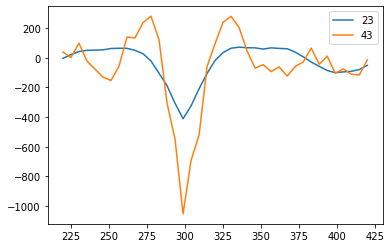

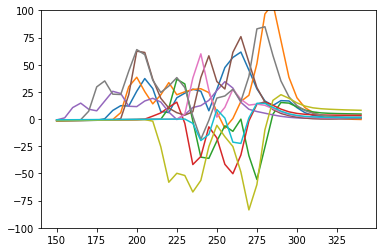

In [4]:
plt.figure()
plt.plot(new_times, beta23_dpl)
plt.plot(new_times, beta43_dpl)
plt.legend(['23', '43'])

plt.figure()
idx = 1
plt.plot(sim_times, np.array(dpl)[idx:idx+10,:].transpose())
plt.ylim([-100,100])

In [5]:
# inference = SNPE(prior=prior)
# inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
# density_estimator = inference.train()
# posterior = inference.build_posterior(density_estimator)

In [6]:
# posterior_files = {
#     'posterior': posterior,
#     'sim_tstart': sim_tstart,
#     'sim_t_end': sim_t_end,
#     'real_tstart': real_tstart,
#     'real_t_end': real_t_end,
#     'dpl': dpl,
#     'theta': theta
# }

# save_file = open(data_path + 'posterior_files.pkl', 'wb')
# dill.dump(posterior_files, save_file)
# save_file.close()

In [7]:
#___Save posterior___
# save_file = open(data_path + 'posterior_100x_downsample.pkl', 'wb')
# dill.dump(posterior, save_file)
# save_file.close()

# np.savetxt(data_path + 'dpl_200-400ms_cropped_100x_downsample.csv', dpl_all, delimiter=',')
# np.savetxt(data_path + 'theta_all.csv', theta_all, delimiter=',')

#___Load posterior___
posterior_file = open(data_path + 'posterior_files.pkl', 'rb')
# posterior_file = open(data_path + 'posterior_100x_downsample.pkl', 'rb')
# posterior_file = open(data_path + 'posterior_200-400ms_cropped_100x_downsample.pkl', 'rb')
posterior = dill.load(posterior_file)
posterior_file.close()
locals().update(posterior)

In [8]:
# num_samples = 8
# theta_samples_beta23 = posterior.sample((num_samples,), x=beta23_dpl)
# theta_samples_beta43 = posterior.sample((num_samples,), x=beta43_dpl)

In [9]:
# res_beta23 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta23[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
# res_beta43 = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_beta43[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))


In [10]:
# plt.figure(figsize=(8,6))
# # plt.plot(new_times, beta23_dpl, 'C0', LineWidth=3)
# # plt.plot(new_times, beta43_dpl, 'C1',LineWidth=3)
# plt.legend(['beta23', 'beta43'])
# for sim_idx in range(len(res_beta23)):
#     plt.plot(np.linspace(20,520,10001), res_beta23[sim_idx][0], 'C0', LineStyle='--', alpha=0.5)
# # for sim_idx in range(len(res_beta43)-4):
# #     plt.plot(np.linspace(20,520,10001), res_beta43[sim_idx][0], 'C1', LineStyle='--', alpha=0.5)

# plt.ylim([-40,40])
# plt.title('Inferred Beta23 (8 samples)')
# plt.xlim([100,500])


In [11]:
param_names = ['dipole scale fctr', 'prox. time', 'prox. variance', '# prox. spikes', 'prox. g_ampa L2/3 PN', 'prox. g_ampa L5 PN', 'dist. time', 'dist. variance', '# dist. spikes', 'dist. g_ampa L2/3 PN', 'dist. g_ampa L5 PN']
limits = [item for key, item in prior_dict.items()]
# subset = [1,2,3,4,5]
subset = list(range(len(param_names)))
plt.rc('axes', labelsize=16)   
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels

In [12]:
# samples = posterior.sample((1000,), x=beta23_dpl)
# _ = utils.pairplot(samples, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

In [13]:
# samples = posterior.sample((1000,), x=beta43_dpl)
# _ = utils.pairplot(samples, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

Condition on 23 yr old dipole

In [14]:
posterior.set_default_x(beta23_dpl)
condition = posterior.sample((1,), x=beta23_dpl)
# posterior.leakage_correction(beta23_dpl, num_rejection_samples=10)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

                        prior support. It may take a long time to collect the remaining
                        0 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.

                        constant for `log_prob()`. However, only 0%
                        posterior samples are within the prior support. It may take a
                        long time to collect the remaining 9998 samples.
                        Consider interrupting (Ctrl-C) and either basing the estimate
                        of the normalizing constant on fewer samples (by calling
                        `posterior.leakage_correction(x_o, num_rejection_samples=N)`,
                        where `N` is the number of samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will result
   

In [16]:
condition = posterior.sample((1,), x=beta23_dpl)
posterior.set_default_x(beta43_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

                        prior support. It may take a long time to collect the remaining
                        0 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.

                        constant for `log_prob()`. However, only 0%
                        posterior samples are within the prior support. It may take a
                        long time to collect the remaining 10000 samples.
                        Consider interrupting (Ctrl-C) and either basing the estimate
                        of the normalizing constant on fewer samples (by calling
                        `posterior.leakage_correction(x_o, num_rejection_samples=N)`,
                        where `N` is the number of samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will result
  

KeyboardInterrupt: 

Condition on 43 yr old dipole

In [15]:
condition = posterior.sample((1,), x=beta43_dpl)
posterior.set_default_x(beta23_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)

                        prior support. It may take a long time to collect the remaining
                        1 samples. Consider interrupting (Ctrl-C)
                        and switching to `sample_with_mcmc=True`.


KeyboardInterrupt: 

In [ ]:
condition = posterior.sample((1,), x=beta43_dpl)
posterior.set_default_x(beta43_dpl)
_ = utils.conditional_pairplot(density=posterior, condition=condition, fig_size=(20,20), labels=param_names, limits=limits, subset=subset)